## DS Challenge
Accelerometer data from 22 people walking.  Explore and exploit the data for subject identification.

See README.md for more information

### Preprocessing & Feature Extraction
**Please see the `accel_magnitude_training.ipynb` notebook for more information about preprocessing and feature extraction**

For simplicity, we will start by looking only at acceleration magnitude.  This has the benefit of being **rotation-invariant**.  If the phone/sensor is oriented differently in their pocket (relative to gravity), all these features will remain the same (as long as the sensitivity is consistent in each x,y,z).

Using the individual x,y,z vectors might provide extra discrimination value, but would require rotating the vectors in the sample to a common reference to accommodate variations in sensor orientation.  One way might be to get the average vector of the sample, and find the rotation matrix to orient the average vector to -z.  Then apply that rotation to all vectors in the sample.  Then we either need to find a way to orient around the z-axis, or transform them to features that are invariant to that rotation.  One idea I have for that calculating xy-angle shift and z-angle shift between successive vectors.

In this notebook we'll start with just analyzing magnitude.

### Classification Approach

Observations:

* Limited data set size
* The data for each subject is modal

Therefore we use a K-Nearest-Neighbors algorithm, which has the benefit of not trying to reduce each subject to a single, average "profile".  As long as their motion matches one of the modes we observed during training, we have a chance to classify it correctly.

In [1]:
import os
import sys

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import json
import sklearn
import time
from accel_utils import AccelUtils
from train_utils import TrainUtils

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import DistanceMetric

In [2]:

%load_ext autoreload
%autoreload 2

In [3]:
# Keep all params in a yaml file for 
params = AccelUtils.read_params_file('params.json')
num_subj = params['num_subj']
max_resample_pts = params['max_resample_pts']
min_timesteps_per_sample = int(params['max_resample_pts'] * params['filt_min_timesteps_per_sample_ratio'])


Params:
{
  "data_dir": "./user_data",
  "filt_avg_power": 2.0,
  "filt_dc_ratio": 0.7,
  "filt_power_ratio": 0.5,
  "filt_min_samples_per_subj": 8,
  "max_dt": 0.035,
  "filt_min_timesteps_per_sample_ratio": 0.9,
  "resample_dt": 0.03,
  "window_size_sec": 4.3,
  "num_subj": 22,
  "max_resample_pts": 139,
  "min_timesteps_per_sample": 125
}
Number of files/subjects: 22
Each sample will be 139 time steps



### Read all .csv, extract valid time windows


In [4]:
per_user_all_data = AccelUtils.read_all_user_data(params['data_dir'], num_subj)

valid_windows_by_user = {}
for i in range(num_subj):
    df = per_user_all_data[i]
    valid_windows_by_user[i] = AccelUtils.extract_valid_time_windows_for_subj(
        df,
        params['window_size_sec'],
        min_timesteps_per_sample)

### Sample Window extraction (subj 3)
Top is the original signal, bottom is all the time slices that will be used for training & testing

Show which time-windows are considered valid by the specified criteria


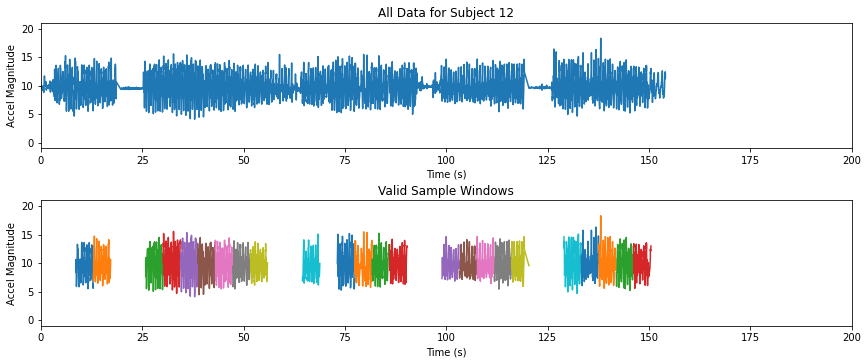

In [5]:
AccelUtils.display_time_slices_for_subject(
    per_user_all_data, 11,
    params['window_size_sec'],
    params['max_dt'])

### Display how many samples we have per subject
We will have to remove anything that has less than 10 samples

Keeping 16 subjects [0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21]


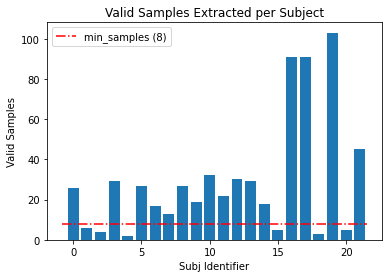

In [6]:
min_samples = params['filt_min_samples_per_subj']
counts = [len(valid_windows_by_user[i]) for i in range(num_subj)]
fig,ax = plt.subplots()
ax.bar(range(num_subj), counts)
ax.plot([-0.8, 21.5], [min_samples, min_samples], 'r-.')
ax.set_xlabel('Subj Identifier')
ax.set_ylabel('Valid Samples')
ax.set_title('Valid Samples Extracted per Subject')
ax.legend([f'min_samples ({min_samples})'])
use_subjs = [i for i in range(num_subj) if counts[i] >= min_samples]
print(f'Keeping {len(use_subjs)} subjects {use_subjs}')

### Compute features for each valid window, split into a train & test set

The features are just the spectral/frequency power for the determinsitic set of frequencies (the same for all samples, since they have the same resampling rate and size)

Total Row Count: 616


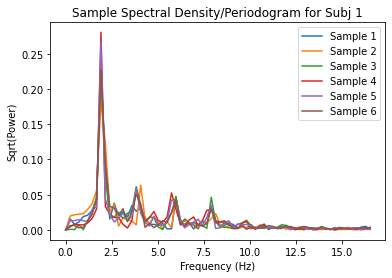

In [7]:
all_rows = []
fig,ax = plt.subplots()
for i_subj in use_subjs:
    for i_win, window in enumerate(valid_windows_by_user[i_subj]):
        fs, pow_norm = AccelUtils.compute_periodogram(
            window,
            params['resample_dt'],
            max_resample_pts)

        if len(pow_norm.tolist()) < max_resample_pts//2:
            continue

        all_rows.append(pow_norm.tolist() + [i_subj])
        
        # Display the first 6 periodograms for subj 0
        if i_subj==0 and i_win < 6:
            ax.plot(fs, pow_norm)
            
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Sqrt(Power)')
ax.set_title(f'Sample Spectral Density/Periodogram for Subj 1')
ax.legend([f'Sample {i+1}' for i in range(6)])
col_headers = [f'f{freq:.1f}' for freq in fs] + ['label']
print('Total Row Count:', len(all_rows))

That looks pretty consistent...

### Some standard data cleaning
Make sure labels are integers, remove any NA values

In [8]:
full_df = pd.DataFrame.from_records(all_rows, columns=col_headers)
full_df.dropna(axis=0, inplace=True)
full_df['label'] = full_df['label'].astype('int32')
print('Total dataset size:', full_df.shape)
full_df.head(5)

Total dataset size: (615, 71)


,f0.0,f0.2,f0.5,f0.7,f1.0,f1.2,f1.4,f1.7,f1.9,f2.2,...,f14.6,f14.9,f15.1,f15.3,f15.6,f15.8,f16.1,f16.3,f16.5,label
0,1.387771e-16,0.015825,0.007720,0.011240,0.018839,0.021067,0.027488,0.043541,0.224552,0.098242,...,0.001623,0.003438,0.003016,0.001707,0.001096,0.000760,0.004056,0.004963,0.001747,0
1,1.903181e-16,0.019632,0.021445,0.022306,0.023109,0.029195,0.037177,0.055577,0.181321,0.123355,...,0.000183,0.000674,0.000465,0.000740,0.001259,0.000867,0.000144,0.000954,0.000667,0
2,5.481318e-17,0.000788,0.000593,0.007369,0.000252,0.013532,0.025359,0.046124,0.229234,0.076757,...,0.001681,0.001334,0.002637,0.002637,0.001815,0.003047,0.000852,0.002104,0.003010,0
3,4.775134e-17,0.004330,0.008085,0.007030,0.007247,0.009892,0.016345,0.029676,0.280399,0.033050,...,0.000091,0.001179,0.002109,0.001908,0.000549,0.000589,0.001808,0.001379,0.003817,0
4,1.428622e-16,0.013254,0.013126,0.014649,0.012782,0.012406,0.028576,0.032763,0.267250,0.043878,...,0.003651,0.001032,0.002499,0.003589,0.000841,0.002613,0.000563,0.001015,0.000860,0


------

## Split the Data into Test and Train Sets
We use sklearn's StratifiedKFold to make sure we get proportional representation of all classes in both test and train sets

In [9]:
num_splits = 5
for i in range(num_splits):
    xt,yt,xs,ys = TrainUtils.get_skf_split(full_df, num_splits, i)
    print(f'Shapes: '
          f'Train: X ~ {xt.shape}, y ~ {yt.shape}  '
          f'Test : X ~ {xs.shape}, y ~ {ys.shape}')

Shapes: Train: X ~ (492, 70), y ~ (492,)  Test : X ~ (123, 70), y ~ (123,)
Shapes: Train: X ~ (492, 70), y ~ (492,)  Test : X ~ (123, 70), y ~ (123,)
Shapes: Train: X ~ (492, 70), y ~ (492,)  Test : X ~ (123, 70), y ~ (123,)
Shapes: Train: X ~ (492, 70), y ~ (492,)  Test : X ~ (123, 70), y ~ (123,)
Shapes: Train: X ~ (492, 70), y ~ (492,)  Test : X ~ (123, 70), y ~ (123,)


### Normalize Input Features
We use sklearn's standard scaler.

NOTE: We switched to purely periodogram-based features, we probably don't want to normalize them...

In [10]:
# We do this if we had std features, but these are periodograms, I don't think it makes sense
_ = """
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We can pickle the scaler to disk to save for later
import pickle
with open('xdata_scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
"""


### Distance Metric Experiment
We need a way to compare periodograms for a KNN classifier.  L2 distance is the default KNN distance metric, which can be our baseline.  KL-Divergence is used for probability distributions and is not symmetric, but seems to have good properties for our application (if we scale our periodogram to sum to 1 like a probibilty density).

So we will try 4 ways to make KL-divergence symmetric and compare it to the default L2 metric

In [11]:
def kl_divergence(a, b):
    valid = a != 0
    return np.sum(a[valid] * np.log(a[valid] / (b[valid] + 1e-8)))

# Make a symmetric distance metric based on KL-divergence-based
def distance_kldiv(y1, y2, pool_method):
    
    # We can create symmetry by computing KL divergence both ways and pooling
    kl1 =  kl_divergence(y1, y2) + 1e-8
    kl2 =  kl_divergence(y2, y1) + 1e-8
    
    if pool_method == 'min':
        return min(kl1, kl2)
    elif pool_method == 'max':
        return max(kl1, kl2)
    elif pool_method == 'sum':
        return kl1 + kl2
    elif pool_method == 'geom':
        return 1.0 / (1.0/kl1 + 1.0/kl2)
    
   

### Create Classifier and Train
"Training" is a funny word to use with KNN -- you just add all the training samples to a list...

In [12]:
for kltype in ['L2', 'min', 'max', 'sum', 'geom']:
    tstart = time.time()
    if kltype in [None, 'L2']:
        # Regular L2 distance
        knn = KNeighborsClassifier(n_neighbors=1)
    else:
        # Try one of the 
        dist_func = lambda a,b: distance_kldiv(a, b, kltype)
        knn = KNeighborsClassifier(n_neighbors=1, metric=dist_func)
                
    y_true_agg, y_pred_agg = TrainUtils.kfold_train_predict(knn, full_df, num_splits=5)
    telapsed = time.time() - tstart
    acc = sklearn.metrics.accuracy_score(y_true_agg, y_pred_agg)
    print('Metric:', kltype.ljust(5), f'Acc: {acc:.4f} ({telapsed:.2f} sec)')


Metric: L2    Acc: 0.6081 (0.03 sec)
Metric: min   Acc: 0.5854 (4.72 sec)
Metric: max   Acc: 0.5772 (4.84 sec)
Metric: sum   Acc: 0.5837 (4.69 sec)
Metric: geom  Acc: 0.5821 (4.87 sec)


## Hmmm...
It really looks like none of the KL-divergence options were worth the trouble.  And they're waaaay slower (not sure how much it has to do with the KL-div calc itself vs using custom distance metric with KNN, which was mentioned in the sklearn docs).

My guess is that KL-divergence cares too much about non-dominant frequencies, whereas L2 distance is most heavily influenced by the dominant frequencies.

------

Let's look at the classification report for one model using the default L2 distance.  

In [13]:
knn = KNeighborsClassifier(n_neighbors=1)
y_true_agg, y_pred_agg = TrainUtils.kfold_train_predict(knn, full_df, num_splits=5)
print(sklearn.metrics.classification_report(y_true_agg, y_pred_agg))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           3       0.50      0.52      0.51        29
           5       0.65      0.41      0.50        27
           6       0.30      0.18      0.22        17
           7       0.20      0.15      0.17        13
           8       0.43      0.44      0.44        27
           9       0.43      0.47      0.45        19
          10       0.54      0.66      0.59        32
          11       0.21      0.27      0.24        22
          12       0.57      0.57      0.57        30
          13       0.40      0.21      0.27        29
          14       0.88      0.78      0.82        18
          16       0.77      0.78      0.77        90
          17       0.55      0.58      0.57        89
          19       0.73      0.80      0.76       103
          21       0.71      0.68      0.70        44

    accuracy                           0.61       615
   macro avg       0.54   

Confusion Matrix


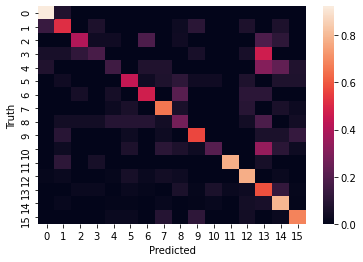

In [14]:
fig,ax = plt.subplots()
ax = sns.heatmap(sklearn.metrics.confusion_matrix(y_true_agg, y_pred_agg, labels=use_subjs, normalize='true'), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
print('Confusion Matrix')

fig.savefig('confusion_matrix.png')

Confusion Matrix isn't all that exciting...

-----

-----

### Hyperparameter search
Define a single, parameterized, end-to-end dataset-preprocessing-splitting-training method.

In [99]:
try:
    import GPyOpt
    from GPyOpt.methods import BayesianOptimization
except:
    print('GPyOpt module not installed.  Remainder of notebook cannot be run without it')
    print('It can easily be installed via "pip install gpyopt"')
    raise
    
# This only needs to be loaded from file once
params = AccelUtils.read_params_file('params.json')
num_subj = params['num_subj']
per_user_all_data = AccelUtils.read_all_user_data(params['data_dir'], num_subj)
global_results = []  # List((num_subj, accuracy, params))

# Parameterized training method, mostly with copied fragments from the rest of the notebook
def parameterized_train(hyperparams):
    max_resample_pts = hyperparams['max_resample_pts']
    n_subj = hyperparams['num_subj']
    min_samples = hyperparams['filt_min_samples_per_subj']
    min_timesteps_per_sample = int(hyperparams['max_resample_pts'] *
                                   hyperparams['filt_min_timesteps_per_sample_ratio'])

    valid_windows_by_user = {}
    for i in range(n_subj):
        df = per_user_all_data[i]
        valid_windows_by_user[i] = AccelUtils.extract_valid_time_windows_for_subj(
            df,
            hyperparams['window_size_sec'],
            min_timesteps_per_sample)

    counts = [len(valid_windows_by_user[i]) for i in range(n_subj)]
    use_subjs = [i for i in range(n_subj) if counts[i] >= min_samples]

    all_rows = []
    for i_subj in use_subjs:
        for i_win, window in enumerate(valid_windows_by_user[i_subj]):
            fs, pow_norm = AccelUtils.compute_periodogram(
                window,
                hyperparams['resample_dt'],
                max_resample_pts)

            if len(pow_norm.tolist()) < max_resample_pts//2:
                continue

            all_rows.append(pow_norm.tolist() + [i_subj])

    col_headers = [f'freq_{i:02d}' for i in range(len(all_rows[0]))]
    col_headers[-1] = 'label'
    full_df = pd.DataFrame.from_records(all_rows, columns=col_headers)
    full_df.dropna(axis=0, inplace=True)
    full_df['label'] = full_df['label'].astype('int32')

    knn = KNeighborsClassifier(n_neighbors=1)
    y_true_agg, y_pred_agg = TrainUtils.kfold_train_predict(knn, full_df, num_splits=5)
    acc = sklearn.metrics.accuracy_score(y_true_agg, y_pred_agg)

    global_results.append((len(use_subjs), acc, hyperparams))
    return acc

print(f'Accuracy: {parameterized_train(params):.3f}')
print(f'Results List:', global_results)


Params:
{
  "data_dir": "./user_data",
  "filt_avg_power": 2.0,
  "filt_dc_ratio": 0.7,
  "filt_power_ratio": 0.5,
  "filt_min_samples_per_subj": 8,
  "max_dt": 0.035,
  "filt_min_timesteps_per_sample_ratio": 0.9,
  "resample_dt": 0.03,
  "window_size_sec": 4.3,
  "num_subj": 22,
  "max_resample_pts": 139,
  "min_timesteps_per_sample": 125
}
Number of files/subjects: 22
Each sample will be 139 time steps
Accuracy: 0.608
Results List: [(16, 0.608130081300813, {'data_dir': './user_data', 'filt_avg_power': 2.0, 'filt_dc_ratio': 0.7, 'filt_power_ratio': 0.5, 'filt_min_samples_per_subj': 8, 'max_dt': 0.035, 'filt_min_timesteps_per_sample_ratio': 0.9, 'resample_dt': 0.03, 'window_size_sec': 4.3, 'num_subj': 22, 'max_resample_pts': 139, 'min_timesteps_per_sample': 125})]


### A quick grid search over just window size
I'll do the full parameter search with GPyOpt after this

In [100]:
default_params = params.copy()
def eval_with_params(hyperparams):
    test_params = default_params.copy()
    test_params.update(hyperparams)
    AccelUtils.recompute_dervied_params(test_params)

    acc = parameterized_train(test_params)
    nsubj = global_results[-1][0]
    return acc


global_results = []
for w in np.arange(2.0, 6.0, step=0.1):
    upd_params = {'window_size_sec': w}
    acc = eval_with_params(upd_params)
    nsubj = global_results[-1][0]
    print(f'Tested window size={w:.1f}, accuracy: {acc:.3f} (#subj={nsubj})')

Tested window size=2.0, accuracy: 0.522 (#subj=20)
Tested window size=2.1, accuracy: 0.487 (#subj=20)
Tested window size=2.2, accuracy: 0.519 (#subj=19)
Tested window size=2.3, accuracy: 0.557 (#subj=20)
Tested window size=2.4, accuracy: 0.543 (#subj=19)
Tested window size=2.5, accuracy: 0.540 (#subj=18)
Tested window size=2.6, accuracy: 0.550 (#subj=18)
Tested window size=2.7, accuracy: 0.563 (#subj=18)
Tested window size=2.8, accuracy: 0.566 (#subj=19)
Tested window size=2.9, accuracy: 0.566 (#subj=18)
Tested window size=3.0, accuracy: 0.541 (#subj=19)
Tested window size=3.1, accuracy: 0.538 (#subj=18)
Tested window size=3.2, accuracy: 0.576 (#subj=18)
Tested window size=3.3, accuracy: 0.610 (#subj=16)
Tested window size=3.4, accuracy: 0.570 (#subj=17)
Tested window size=3.5, accuracy: 0.556 (#subj=18)
Tested window size=3.6, accuracy: 0.563 (#subj=18)
Tested window size=3.7, accuracy: 0.537 (#subj=17)
Tested window size=3.8, accuracy: 0.594 (#subj=16)
Tested window size=3.9, accurac

Text(0.5, 1.0, 'Accuracy as a function of time window')

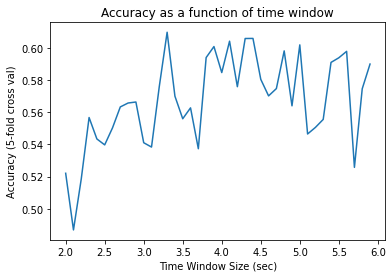

In [101]:
fig, ax = plt.subplots()
windows = [p['window_size_sec'] for _, _, p in global_results]
accs = [acc for _, acc, _ in global_results]
ax.plot(windows, accs)
ax.set_xlabel('Time Window Size (sec)')
ax.set_ylabel('Accuracy (5-fold cross val)')
ax.set_title('Accuracy as a function of time window')


In [102]:
# GPyOpt seems to only be willing to pass tuples, not dictionaries... annoying
# So create yet another wrapper...
def create_eval_with_params_tuple(domain):
    kwarg_names = [var_dict['name'] for var_dict in domain]

    def out_func(param_tuple):
        kwargs = {}
        for i,v in enumerate(param_tuple[0]):
            kwargs[kwarg_names[i]] = v

        acc = eval_with_params(kwargs)
        return acc

    return out_func


Best params: [2.39123691 4.54859733]
Best Accuracy: 0.6230636833046471


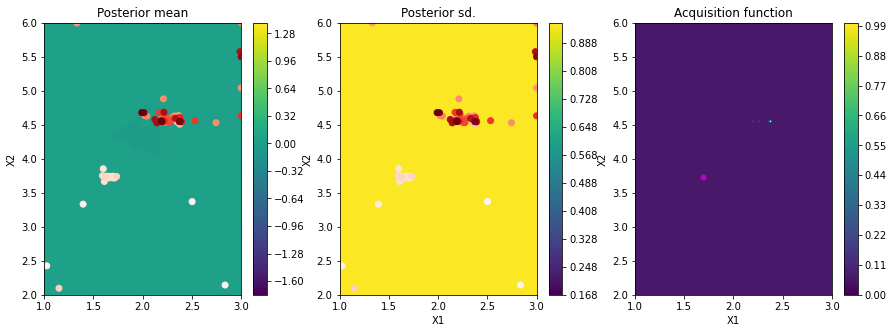

In [103]:
domain = [
  {'name': 'filt_avg_power',   'type': 'continuous', 'domain': (1.0, 3.0)},
  {'name': "window_size_sec",  'type': 'continuous', 'domain': (2.0, 6.0)},
]

myBopt = BayesianOptimization(
    f=create_eval_with_params_tuple(domain),
    domain=domain,
    maximize=True,
    verbosity=True)
myBopt.run_optimization(max_iter=100)

print('Best params:', myBopt.x_opt)
print('Best Accuracy:', myBopt.Y_best[-1])

myBopt.plot_acquisition()


